## Hand-crafted graph features

-  Найти или сгенерировать набор данных для бинарной классификации графов.
-  Реализовать функцию `shortest_path_kernel(train_graphs, test_graphs)`, которая принимает тренировочный и тестовые наборы, а возвращает пару `K_train, K_test`
  - Опишите графы с помощью вектора из количества кратчайших путей различной длины
  - Для вычисления длин кратчайших путей можно использовать `nx.shortest_path_length(G)`
  - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
  - `K_train` - матрица из ядровых функций для сравнения тренировочных графов между собой
  - `K_test` - матрица из ядровых функций для сравнения тестовых графов с тренировочными
    
- Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества

In [28]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from datasets import load_dataset

Используем датасет ```IMDB-BINARY```. Графы представляют социальные сети из базы данных фильмов IMDB, где узлы — это актеры, а ребра обозначают совместные проекты.

In [2]:
data = load_dataset("graphs-datasets/IMDB-BINARY");

split_data = data['train'].train_test_split(test_size=0.2)

train_dataset = split_data['train']
test_dataset = split_data['test']

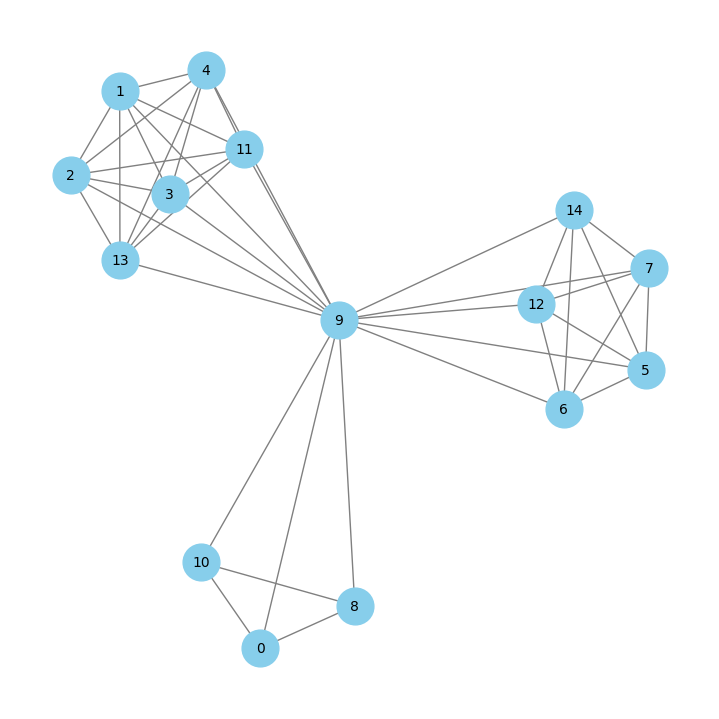

In [10]:
data = train_dataset[0]
edge_index = data['edge_index']
num_nodes = data['num_nodes']

graph = nx.Graph()

edges = list(zip(edge_index[0], edge_index[1]))
graph.add_edges_from(edges)

plt.figure(figsize=(7, 7))
nx.draw(graph, with_labels=True, node_color="skyblue", node_size=700, font_size=10, edge_color="gray")
plt.show()

In [3]:
train_graphs = []
for i in range(len(train_dataset)):
    G = nx.Graph()
    num_nodes = train_dataset[i]['num_nodes']
    edge_index = train_dataset[i]['edge_index']

    for node_id in range(num_nodes):
        G.add_node(node_id)
    edges = list(zip(edge_index[0], edge_index[1]))
    G.add_edges_from(edges)
    train_graphs.append(G)

test_graphs = []
for i in range(len(test_dataset)):
    G = nx.Graph()
    num_nodes = test_dataset[i]['num_nodes']
    edge_index = test_dataset[i]['edge_index']

    for node_id in range(num_nodes):
        G.add_node(node_id)

    edges = list(zip(edge_index[0], edge_index[1]))
    G.add_edges_from(edges)
    test_graphs.append(G)

In [10]:
def shortest_path_kernel(train_graphs, test_graphs):
    max_path_length = 0
    
    for graph in train_graphs:
        if nx.is_connected(graph):
            max_path_length = max(max_path_length, nx.diameter(graph))
        else:
            lengths = dict(nx.all_pairs_shortest_path_length(graph))
            longest_path_length = max(max(lengths[node].values()) for node in lengths)
            max_path_length = max(max_path_length, longest_path_length)

    for graph in test_graphs:
        if nx.is_connected(graph):
            max_path_length = max(max_path_length, nx.diameter(graph))

    phi_train = np.zeros((len(train_graphs), max_path_length))
    for i, graph in enumerate(train_graphs):
        shortest_paths = dict(nx.shortest_path_length(graph))
        for source, paths in shortest_paths.items():
            for target, length in paths.items():
                if length < max_path_length:
                    phi_train[i, length] += 1

    phi_test = np.zeros((len(test_graphs), max_path_length))
    for i, graph in enumerate(test_graphs):
        shortest_paths = dict(nx.shortest_path_length(graph))
        for source, paths in shortest_paths.items():
            for target, length in paths.items():
                if length < max_path_length:
                    phi_test[i, length] += 1

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test

In [11]:
K_train_gk, K_test_gk = shortest_path_kernel(train_graphs, test_graphs)

print(K_train_gk.shape, K_test_gk.shape)

(800, 800) (200, 800)


In [12]:
train_y = np.array(train_dataset['y']).ravel()
test_y = np.array(test_dataset['y']).ravel()

In [22]:
def select_hyperparameters_and_calculate_metrics(K_train_gk, K_test_gk, train_y, test_y):
    param_grid = {
        'C': [0.01, 0.1, 1],
        'tol': [0.1, 0.01, 0.001, 0.0001]
    }
    
    svc = SVC(kernel='precomputed', random_state=42, class_weight='balanced')
    
    grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=2)
    grid_search.fit(K_train_gk, train_y)
    
    best_params = grid_search.best_params_
    print("Лучшие гиперпараметры: ", best_params)
    
    best_model = grid_search.best_estimator_
    pred_y = best_model.predict(K_test_gk)
    
    accuracy = accuracy_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y)
    recall = recall_score(test_y, pred_y)
    f1 = f1_score(test_y, pred_y)
    
    print("accuracy: ", accuracy)
    print("precision: ", precision)
    print("recall: ", recall)
    print("F1: ", f1)

In [23]:
select_hyperparameters_and_calculate_metrics(K_train_gk, K_test_gk, train_y, test_y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ....................................C=0.01, tol=0.1; total time=   0.1s
[CV] END ....................................C=0.01, tol=0.1; total time=   0.1s
[CV] END ....................................C=0.01, tol=0.1; total time=   0.0s
[CV] END ....................................C=0.01, tol=0.1; total time=   0.0s
[CV] END ....................................C=0.01, tol=0.1; total time=   0.0s
[CV] END ...................................C=0.01, tol=0.01; total time=   0.0s
[CV] END ...................................C=0.01, tol=0.01; total time=   0.0s
[CV] END ...................................C=0.01, tol=0.01; total time=   0.1s
[CV] END ...................................C=0.01, tol=0.01; total time=   0.0s
[CV] END ...................................C=0.01, tol=0.01; total time=   0.0s
[CV] END ..................................C=0.01, tol=0.001; total time=   0.0s
[CV] END ..................................C=0.0